In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.7 MB/s eta 0:00:00


In [3]:
import os
import gc
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import re
import html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam, SGD, AdamW, RAdam
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold,GroupKFold
from sklearn.metrics import log_loss,f1_score,accuracy_score

from transformers import AutoModel, AutoConfig, AutoTokenizer, AdamW, DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)


OUTPUT_EXP_DIR = DIR + '/output/EXP053/'
if not os.path.exists(OUTPUT_EXP_DIR):
    os.makedirs(OUTPUT_EXP_DIR)

In [5]:
class CFG:
    ver=53
    num_workers=4
    path=OUTPUT_EXP_DIR
    config_path=path+'config.pth'
    model="microsoft/deberta-base"
    batch_size=128
    fc_dropout=0.2
    target="is_fraud?"
    target_size=1
    max_len=105
    seed=42
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    gradient_checkpointing=False
    freezing=False

In [6]:
def get_score(labels, outputs):
    y_pred = outputs
    y_true = labels
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.80, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(y_true, (y_pred>thresh).astype(int))
        #print("Accuracy score at threshold {0} is {1}".format(thresh, score))
        if score > best_score:
          best_score = score
          best_thresh = thresh
    return f1_score(y_true, (y_pred>best_thresh).astype(int)), best_thresh



def get_logger(filename=OUTPUT_EXP_DIR+'inference'):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=CFG.seed)

In [7]:

def freeze(module):
    """
    Freezes module's parameters.
    """

    for parameter in module.parameters():
        parameter.requires_grad = False

def get_freezed_parameters(module):
    """
    Returns names of freezed parameters of the given module.
    """

    freezed_parameters = []
    for name, parameter in module.named_parameters():
        if not parameter.requires_grad:
            freezed_parameters.append(name)

    return freezed_parameters

def set_embedding_parameters_bits(embeddings_path, optim_bits=32):
    """
    https://github.com/huggingface/transformers/issues/14819#issuecomment-1003427930
    """

    embedding_types = ("word", "position", "token_type")
    for embedding_type in embedding_types:
        attr_name = f"{embedding_type}_embeddings"

        if hasattr(embeddings_path, attr_name):
            bnb.optim.GlobalOptimManager.get_instance().register_module_override(
                getattr(embeddings_path, attr_name), 'weight', {'optim_bits': optim_bits}
            )

In [8]:
oof_df = pd.read_pickle(CFG.path+'oof_df.pkl')
labels = oof_df[CFG.target].values
preds = oof_df['pred'].values
score, thresh = get_score(labels, preds)
CFG.oof_score = score
LOGGER.info(f'CV Score(thresh = {thresh}): {score:<.4f}')

CV Score(thresh = 0.28): 0.5457
INFO:__main__:CV Score(thresh = 0.28): 0.5457


In [9]:
test = pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
card = pd.read_csv(os.path.join(INPUT_DIR, "card.csv"))
user = pd.read_csv(os.path.join(INPUT_DIR, "user.csv"))
sub = pd.read_csv(os.path.join(INPUT_DIR, "sample_submit.csv"), header=None)

print(test.shape)
display(test.head(3))

print(card.shape)
display(card.head(3))

print(user.shape)
display(user.head(3))

print(sub.shape)
display(sub.head(3))

(457958, 11)


,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,471283,541,3,$113.278,OK,324189,Orlando,FL,32821.0,4814,Swipe Transaction
1,471284,655,1,$293.944,OK,81219,Ridgefield,WA,98642.0,7538,Chip Transaction
2,471285,492,0,$47.4,OK,274755,Arlington Heights,IL,60004.0,5719,Swipe Transaction


(416, 10)


,user_id,card_id,card_brand,card_type,expires,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,39,0,Visa,Debit,09/2021,YES,1,$17117,05/2007,2010
1,39,1,Amex,Credit,11/2024,YES,2,$5400,10/2015,2015
2,41,0,Discover,Credit,03/2022,YES,2,$14800,12/2010,2011


(97, 17)


,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,39,57,64,1962,12,Female,442 Burns Boulevard,Mansfield,MA,2048,42.02,-71.21,$37407,$76274,$102611,698,2
1,41,39,66,1980,10,Female,3863 River Avenue,Lincoln,CA,95648,38.93,-121.25,$21829,$44506,$57994,849,3
2,47,40,67,1979,5,Female,8799 Elm Avenue,Mckinney,TX,75069,33.20,-96.65,$24684,$50329,$76759,625,4


(457958, 2)


,0,1
0,471283,0
1,471284,1
2,471285,0


In [10]:
month_dict = {
   "01": "January",
   "02": "February",
   "03": "March",
   "04": "April",
   "05": "May",
   "06": "June",
   "07": "July",
   "08": "August",
   "09": "September",
   "10": "October",
   "11": "November",
   "12": "December"
}

def get_expires_values(df):
  _df = df["expires"].str.split('/').apply(pd.Series)
  _df.columns = ["month","years"]
  df["expires_month"] = _df["month"].astype(str)
  df["expires_years"] = _df["years"].astype(str)
  return df

def get_acct_open_date_values(df):
  _df = df["acct_open_date"].str.split('/').apply(pd.Series)
  _df.columns = ["month","years"]
  df["acct_open_date_month"] = _df["month"].astype(str)
  df["acct_open_date_years"] = _df["years"].astype(str)
  return df


card = get_expires_values(card)
card = get_acct_open_date_values(card)
card["expires_month"] = card["expires_month"].map(month_dict)
card["acct_open_date_month"] = card["acct_open_date_month"].map(month_dict)

In [11]:
test = test.merge(card, how="left", on=["user_id", "card_id"]).merge(user, how="left", on="user_id")

In [12]:
test.fillna('unknown', inplace = True)

test["texts"] = "merchant" + "[SEP]" + test["amount"] + "[SEP]" + test["errors?"] + "[SEP]" + test["merchant_city"] + "[SEP]" + test["merchant_state"] + "[SEP]" + test["use_chip"] + "[SEP]" \
+ "card" + "[SEP]" + test["card_brand"] + "[SEP]" + test["card_type"] + "[SEP]" + test["expires_month"] + " " + test["expires_years"] + "[SEP]" + test["has_chip"] + "[SEP]" + test["acct_open_date_month"] + " " + test["acct_open_date_years"] + "[SEP]" + test["year_pin_last_changed"].astype(str) + "[SEP]" \
"user" + "[SEP]" + test["current_age"].astype(str) + " year old " + test["gender"] + "[SEP]" + "retired at age " + test["retirement_age"].astype(str) + "[SEP]" + test["address"] + "[SEP]" + test["city"] + "[SEP]" + test["state"] + "[SEP]" + test["per_capita_income_zipcode"] + "[SEP]" + test["yearly_income_person"] + "[SEP]" + test["total_debt"]

In [13]:
# ====================================================
# tokenizer
# ====================================================
CFG.tokenizer = AutoTokenizer.from_pretrained(CFG.path+'tokenizer/')

In [14]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False,
                           truncation=True)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.inputs = df['texts'].values

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.inputs[item])
        return inputs

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

In [15]:
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings


class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # Freezing
        if cfg.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            cfg.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())

        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, cfg.target_size)
        self._init_weights(self.fc)
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        feature = self.layer_norm1(feature)
        output = self.fc(feature)
        return output

In [16]:
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [17]:
test_dataset = TestDataset(CFG, test)
test_loader = DataLoader(test_dataset,
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
predictions = []
for fold in CFG.trn_fold:
    model = CustomModel(CFG, config_path=CFG.config_path, pretrained=False)
    state = torch.load(CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader, model, device)
    predictions.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
prediction = np.mean(predictions, axis=0)

100%|██████████| 3578/3578 [11:50<00:00,  5.03it/s]


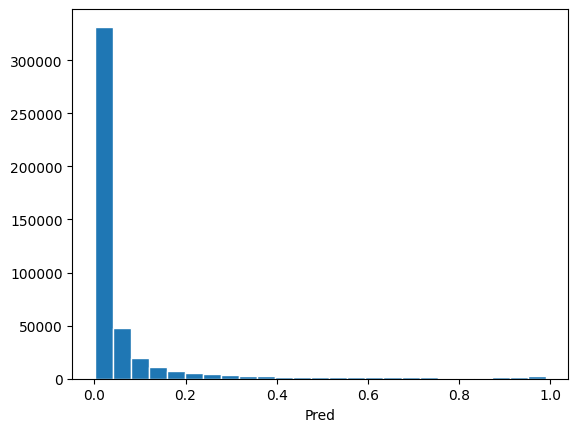

,index,is_fraud?
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


0    426776
1     31182
Name: is_fraud?, dtype: int64

In [18]:
submit = sub.copy()
submit.columns = ["index","pred"]

submit['pred'] = prediction
submit[CFG.target] = (prediction>thresh).astype(int)
submit["pred_fold0"] = predictions[0]
submit["pred_fold1"] = predictions[1]
submit["pred_fold2"] = predictions[2]
submit["pred_fold3"] = predictions[3]
submit["pred_fold4"] = predictions[4]

submit[["index","is_fraud?"]].to_csv(os.path.join(OUTPUT_DIR, f"submition_{CFG.model.replace('/', '-')}_seed{CFG.seed}_ver{CFG.ver}.csv"),index=False)

plt.hist(prediction, bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit[["index","is_fraud?"]])
display(submit[CFG.target].value_counts())

In [ ]:
submit.to_csv(os.path.join(SUB_NUM_DIR, f"submit_num_{CFG.model.replace('/', '-')}_seed{CFG.seed}_ver{CFG.ver}.csv"), index=False, header=None)
display(submit.head())

,index,pred,is_fraud?,pred_fold0,pred_fold1,pred_fold2,pred_fold3,pred_fold4
0,471283,0.022359,0,0.023197,0.022952,0.025630,0.017751,0.022264
1,471284,0.171990,0,0.217467,0.237890,0.113296,0.140579,0.150716
2,471285,0.024131,0,0.036245,0.008957,0.043597,0.020419,0.011440
3,471286,0.666195,1,0.619853,0.671194,0.538711,0.783136,0.718080
4,471287,0.006287,0,0.005102,0.005315,0.011761,0.005917,0.003341


In [ ]:
from google.colab import runtime
runtime.unassign()